# TP2: Filter Banks

By Daniel Jorge Deutsch, Kevin Kuhl and Brayam Santiago Velandia (25/09/2020)

In [81]:
import os
import struct
import sys
import time
import warnings
import wave
from copy import deepcopy
from math import ceil
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyaudio
from scipy import signal as sig
from scipy.io import wavfile

In [82]:
class Base:

    def __init__(self, name, data):
        self.name = name 
        self.data = np.asarray(data)

    
    #------------------------------#
    #--- SAMPLES ------------------#
    #------------------------------#

    def step_split_sample(self, step):
        datas = [self.data[i::step] for i in range(step)]
        max_len = max([len(data) for data in datas])
        for i, data in enumerate(datas):
            if len(data) != max_len:
                datas[i] = np.append(data, 0)
            datas[i] = self.__class__(f"{self.name}{i}", datas[i])
        return tuple(datas) 



    #------------------------------#
    #--- PLOTS --------------------#
    #------------------------------#
    
    def data_plot(self, discrete=False, absolute=False, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):
        plt.figure(figsize=figsize)
        if discrete:
            if absolute:
                plt.stem(np.abs(self.data))
            else:
                plt.stem(self.data)
        else:
            if absolute:
                plt.plot(np.abs(self.data))
            else:
                plt.plot(self.data)
        plt.xlim(0, len(self.data)-1)
        plt.ylabel("Amplitude")
        plt.xlabel("Index")
        plt.title(f"Plot of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.axhline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_data.png", dpi=300, bbox_inches="tight")
        plt.show()


    def spectrogram_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):
        
        # Obtain the spectrogram params
        f, t, Sxx = sig.spectrogram(self.data, self.freq)

        # Plot
        plt.figure(figsize=figsize)
        plt.pcolormesh(t, f, 20*np.log10(Sxx), shading="auto")
        plt.ylabel("Frequency [Hz]")
        plt.xlabel("Time [s]")
        plt.title(f"Spectogram of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.axhline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_spectrogram.png", dpi=300, bbox_inches="tight")
        plt.show()


    # Should use when you have the filter's coefficients
    def freqz_plot(self, whole=False, absolute=True, db=True, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):

        len_fft = 4096 if whole else 2048                            # Length of the transformed axis of the output
        freq, mag = sig.freqz(self.data, worN=len_fft, whole=whole)  # Obtains the frequency and magnitude

        # Magnitude
        if absolute:
            mag = np.abs(mag)
        if db:
            mag = 20*np.log10(mag)
        mag[np.abs(mag-np.mean(mag)) > 2*np.std(mag)] = np.nan   # Remove outliers for the plot

        # Frequency   
        freq = freq/(2*np.pi)
        
        # Plot
        plt.figure(figsize=figsize)
        plt.plot(freq, mag)
        plt.xlim(freq[0], freq[-1])
        if db:
            plt.ylabel("Magnitude [dB]")
        else:
            plt.ylabel("Magnitude")
        plt.xlabel("Frequency [(rad/sample)/2π]")
        plt.title(f"Frequency response of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.axhline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_freqz.png", dpi=300, bbox_inches="tight")
        plt.show() 

    
    #def compare_plot(self, signal, plot_type, absolute=True, db=True, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):
     #   if

In [83]:
class Signal(Base):

    def __init__(self, name, data=None, freq=None, file=None):
        if not ((data is None) ^ (file == None)):
            raise Exception("You must provide a data or a .wav file")
        if file:
            freq, data = wavfile.read(file)
        self.freq = int(freq) if freq else freq
        Base.__init__(self, name, data)


    #------------------------------#
    #--- SHIFTING -----------------#
    #------------------------------#

    def shift(self, name, power_of_z):
        data = self.data
        data = np.append(data[power_of_z:], power_of_z*[0]) if power_of_z > 0 else np.append(abs(power_of_z)*[0], data[:power_of_z])
        return self.__class__(name, data, self.freq)


    #------------------------------#
    #--- SAMPLING -----------------#
    #------------------------------#

    def under_sample(self, name, M):
        datas = self.step_split_sample(M)
        return self.__class__(name=name, data=datas[0].data, freq=self.freq/M)


    def over_sample(self, name, L):
        data = np.insert(self.data, range(1, len(self.data)+1)[::L-1], 0)
        return self.__class__(name=name, data=data, freq=self.freq*L) 
    

    #------------------------------#
    #--- PLOT ---------------------#
    #------------------------------#

    def time_plot(self, absolute=False, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):

        # Obtains the time axis
        t = np.linspace(0, len(self.data)/self.freq, len(self.data))

        # Plot
        plt.figure(figsize=figsize)
        if absolute:
            plt.plot(t, np.abs(self.data))
        else:
            plt.plot(t, self.data)
        plt.xlim(t[0], t[-1])
        plt.ylabel("Amplitude")
        plt.xlabel("Time [s]")
        plt.title(f"Time plot of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hlines(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_time.png", dpi=300, bbox_inches="tight")
        plt.show()
            

    #------------------------------#
    #--- LISTEN -------------------#
    #------------------------------#

    def listen(self):
        
        # Saves the .wav
        if not self.freq:
            raise Exception("the sample freq (sample/sec) must be provided")
        wavfile.write(f"./outputs/sounds/{self.name}.wav", self.freq, np.asarray(self.data, dtype=np.int16))

        # Uses pyaudio to play the signal
        chunk = 1024
        pa = pyaudio.PyAudio()
        audio = wave.open(f"./outputs/sounds/{self.name}.wav", "rb")
        stream = pa.open(
            format = pa.get_format_from_width(audio.getsampwidth()),
            channels = audio.getnchannels(),
            rate = audio.getframerate(),
            output = True
        )
        data = audio.readframes(chunk)
        while data:
            stream.write(data)
            data = audio.readframes(chunk)
        stream.stop_stream()
        stream.close()
        pa.terminate()

In [84]:
class Filter(Base):

    def apply(self, name, signal):
        conv = np.convolve(self.data, signal.data)
        return Signal(name, data=conv, freq=signal.freq)

# 1.1

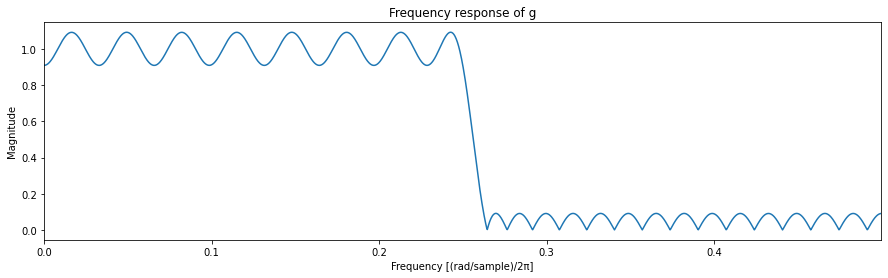

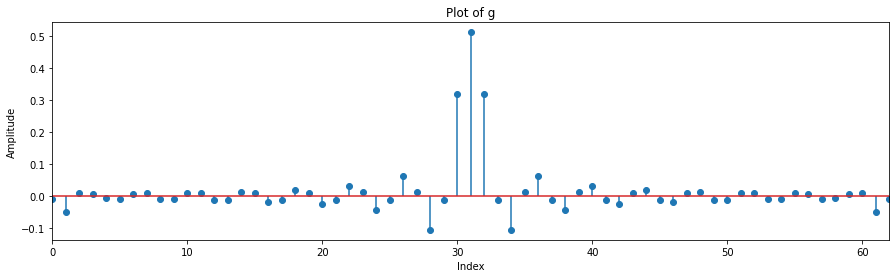

In [85]:
# Defines the Remez filter params
numtaps = 63            # An odd number
trans_width = 1/80      # Transition width
cutoff = 1/4            # Cutoff frequency

# Obtains the Remez filter
g = Filter("g", sig.remez(numtaps, [0, cutoff, cutoff+trans_width, 1/2], [1, 0]))

# By plotting the fft of g we can clearly see that the Chebyshev’s alternance property holds
g.freqz_plot(db=False)

# By plotting g we can clearly see that the half-band condition doesn't hold since one out of two coefficients of g(n) isn't zero
g.data_plot(discrete=True)

# 1.2

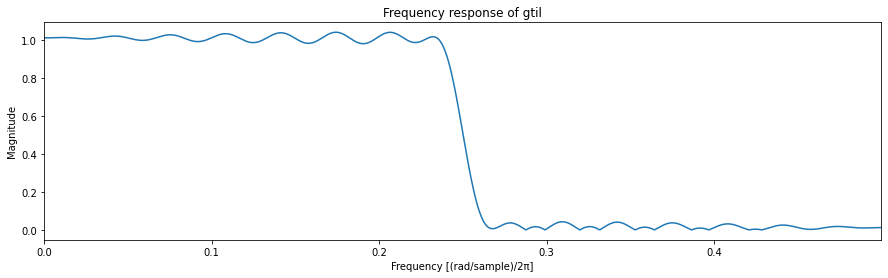

In [86]:
# Creates the filter gtil that cancels one out every two coefficients of the filter g
gtil = Filter("gtil", deepcopy(g.data))
for i, coef in enumerate(gtil.data):
    if i % 2 != 0 and i != int(len(gtil.data)/2):
        gtil.data[i] = 0

# We can see that Chebyshev’s alternance property doesn't hold by plotting the fft of the new filter, since the filter's oscilations don't have the same δ
gtil.freqz_plot(db=False)

# 1.3

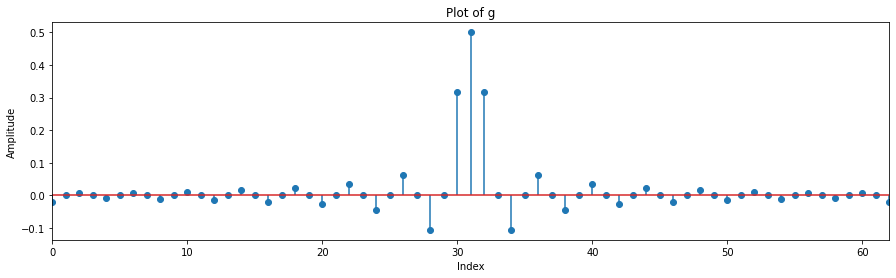

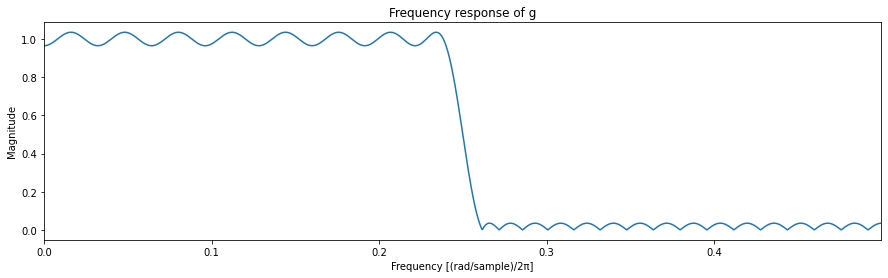

In [87]:
# Defines the Remez filter params
N = 32               # numtaps (an even number)
trans_width = 0.02   # Transition width
cutoff = 0.48        # Cutoff frequency

# Obtains the nearly all-pass type II Remez filter
v = Filter("v", sig.remez(N, [0, cutoff, cutoff+trans_width, 0.5], [1, 0]))

# Obtains the low-pass filter dirived from the filter v
c = 0.5                                                            # Defines the constant c
δ = Filter("δ", (N-1)*[0] + [1] + (N-1)*[0])                       # Obtains the dirac δ(n - (N-1))
v_2 = Filter("v_2", np.insert(v.data, range(1, len(v.data)), 0))   # Obtains the V(z^2) in the time domain
g = Filter("g", c*v_2.data + c*δ.data)                             # Obtains g(n)
g.data_plot(discrete=True)
g.freqz_plot(db=False)

# 1.4

By plotting GR(ν) we can clearly see that it assumes negative values in higher frequencies:



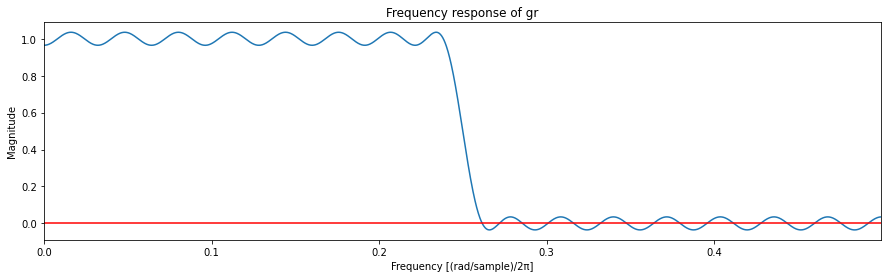


Therefore its impossible to o factorize GR(ν) in the form GR(ν) = Htil0(e2iπν)H0(e2iπν) because the product of Htil0(e2iπν) by H0(e2iπν) is always positive.


In [97]:
# Obtains the magnitude and frequency arrays of g
len_fft = 4096                                            # Sets the size of the signal gr
freq, mag = sig.freqz(g.data, worN=len_fft, whole=True)   # Obtains the frequency (in (rad/sample)/2π) and the magnitude arrays of G(ν)
freq = freq/(2*np.pi)                                     # Converts the frequency to rad/sample

# Obtains the filter gr by doing the inverse Fourrier transformation of Gr(ν) = |G(ν)|*exp(j2πν(N-1))
gr = Filter("gr", np.fft.ifft([mag*np.exp(np.complex(0, 2*np.pi*freq*(N-1))) for freq, mag in zip(freq, mag)]))

# Explains the obtained results
print("By plotting GR(ν) we can clearly see that it assumes negative values in higher frequencies:\n")
gr.freqz_plot(db=False, absolute=False, yhighlights=[0])
print("\nTherefore its impossible to o factorize GR(ν) in the form GR(ν) = Htil0(e2iπν)H0(e2iπν) because the product of Htil0(e2iπν) by H0(e2iπν) is always positive.") 

# 1.5

# 1.6

# 1.7

# 1.8

# 2.1

In [ ]:
# Obtains the input signal x1 and x2 
x1 = Signal(name="x", file="./inputs/femme3.wav")
x2 = Signal(name="x", file="./homme3.wav")

# Defines the over and under sampling constants
L = 2
M = 1

# Defines the Remez filter params
numtaps = 100                       # An even number (can't be too big)
trans_width = 1/13                  # ?
cutoff = min( 1/(2*L), 1/(2*M) )    # Cutoff frequency (should be 1/(2*M) = 1/6)

# Obtains the Remez filter
h = Filter("h", sig.remez(numtaps, [0, cutoff, cutoff+trans_width, 1/2], [L, 0]))

# Runs the system
start_dir = time.perf_counter()      # Start counting (for exercise 2.5)
w1 = x1.over_sample("w1", L)            # Obtains the over sampled signal w using L=2 (Fw=48*2=96kHz)
w2 = x2.over_sample("w2", L)
v1 = h.apply("v1", w1)                  # Calculates the convolution v=w*h
v2 = h.apply("v2", w2)
y1 = v1.under_sample("y1", M)           # Undersample v to obtain the output of the system using M=3 (Fy=96/3=32kHz)
y2 = v2.under_sample("y2", M) 
end_dir = time.perf_counter()        # Ends counting (for exercise 2.5)

#Create mixed signal

r=y1.data + y2.data
from scipy.io.wavfile import write
scaled = np.int16(r/np.max(np.abs(r)) * 32767)
write('mix.wav', y1.freq, scaled)
mix = Signal(name="mix", file="mix.wav")
#mix.listen()
x1.time_plot()
x2.time_plot()
mix.time_plot()


# 2.2

# 2.3

# 2.4